# HomeWork 4 - Autoencoders
### Submitted by Jocelyn Prince (2019/11/20)

### Instructions

Create the autoencoders described below, you can play with the topology, those are just starting points
Use GPU runtime
* Print 10 inputs and their associated outputs
* Don't forget to normalize your data
* Use the Functional API for Keras
Autoencoders to build:

1. Stacked 784 - 392 - 196 - 392 - 784 (tied weights)
2. Convolutional Encoder (conv, maxpool, conv, maxpool, conv, maxpool). Decoder (conv, upsample2d, conv, upsample2d, conv, upsample2d, conv)
3. VAE

-----

# 0. Import Libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import optimizers
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
tf.__version__

'2.0.0'

In [0]:
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

# 0.1 Import MNIST Dataset

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
all_data = np.concatenate((X_train, X_test))
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(all_data.shape)

(55000, 28, 28)
(10000, 28, 28)
(5000, 28, 28)
(65000, 28, 28)


# 1. Functions

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [0]:
def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 3, 6))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [0]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [0]:
K = keras.backend

# 2. Explore data and Simple Autoencoder

In [0]:
def print_first_9(data):
  fig = plt.figure()
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(data[i], interpolation='none')
    plt.title("Digit: {}".format(i))
    plt.xticks([])
    plt.yticks([])

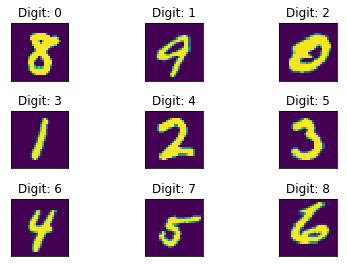

In [0]:
print_first_9(all_data[-9:])

## 2.1 Create Simple Autoencoder

In [0]:
inputs = keras.Input(shape=(28,28))

In [0]:
encoder = layers.Flatten()(inputs)
encoder = layers.Dense(2, activation='relu')(encoder)
decoder = layers.Dense(28*28, activation='relu')(encoder)
output  = layers.Reshape([28,28])(decoder)
simple_autoencoder = keras.Model(inputs, output)
simple_autoencoder.compile(loss='mse', optimizer='adam', metrics=[rounded_accuracy])

In [0]:
t1 = time.time()
hist = simple_autoencoder.fit(X_train, 
                              X_train, 
                              epochs=20, 
                              verbose = 0)
t2 = time.time()
print("Execution time: {0:5.1f} min for {1:3.0f} epochs".format((t2 - t1)/60, len(hist.epoch)))

Execution time:   1.4 min for  20 epochs


In [0]:
simple_encoder = keras.Model(inputs, encoder)
X_valid_compressed = simple_encoder.predict(X_valid)
tsne = TSNE()

X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

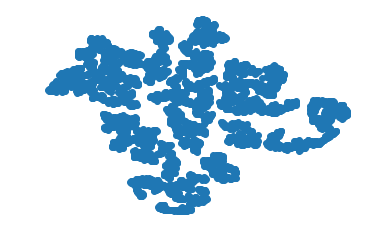

In [0]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1])
plt.axis("off")
plt.show()

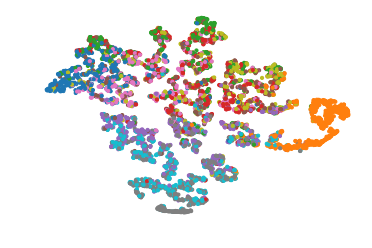

In [0]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

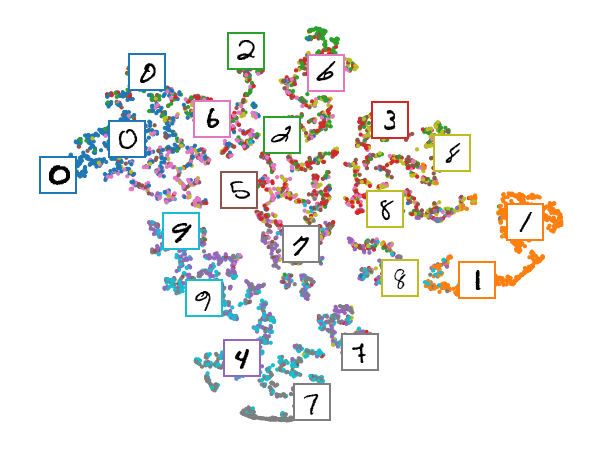

In [0]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

# 3. Questions

## 3.1 Question #1 Stacked 784 - 392 - 196 - 392 - 784 (tied weights)

### 3.1.1 Create Model

In [0]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [0]:
inputs = keras.Input(shape=(28,28))

In [0]:
dense_1 = Dense(392, activation='relu')
dense_2 = Dense(196, activation='relu')
tied_1 = DenseTranspose(dense_2, activation='relu')
tied_2 = DenseTranspose(dense_1, activation='sigmoid')

x = Flatten()(inputs)
x = dense_1(x)
x = dense_2(x)
x = tied_1(x)
x = tied_2(x)
output = layers.Reshape([28,28])(x)
stacked_autoencoder = keras.Model(inputs, output)
stacked_autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=[rounded_accuracy])

In [0]:
stacked_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_3 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_transpose (DenseTransp (None, 392)               77420     
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 784)               308504    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0   

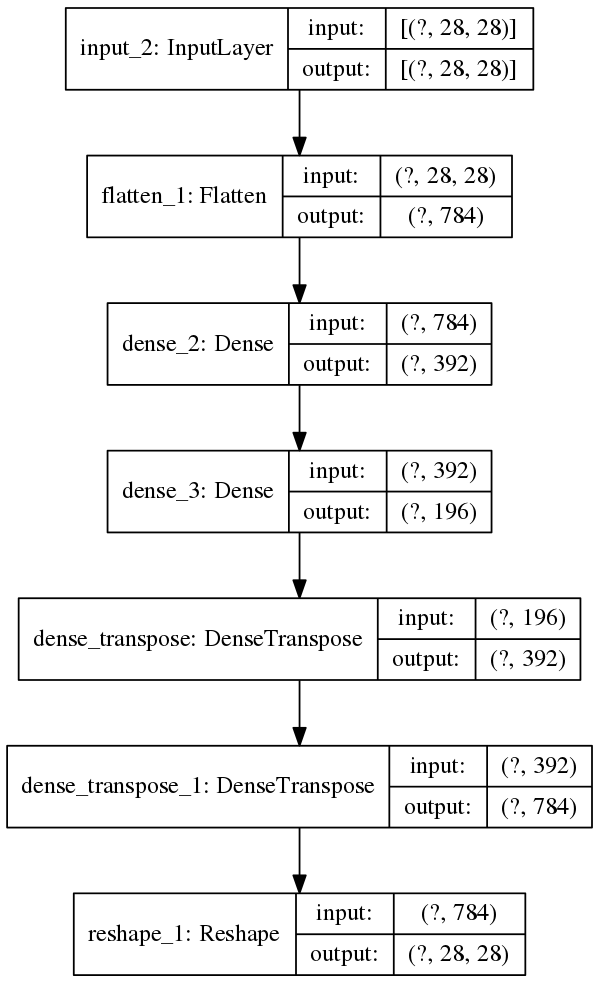

In [0]:
keras.utils.plot_model(stacked_autoencoder, to_file='model.png',show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=128)

### 3.1.2 Execute Model

In [0]:
t1 = time.time()
stacked_hist = stacked_autoencoder.fit(X_train, X_train, epochs=20, 
                                       validation_data=[X_valid, X_valid], 
                                       verbose = 1)
t2 = time.time()
print("Execution time: {0:5.1f} min for {1:3.0f} epochs".format((t2 - t1)/60, len(stacked_hist.epoch)))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 110us/sample - loss: 0.0955 - rounded_accuracy: 0.9703 - val_loss: 0.0760 - val_rounded_accuracy: 0.9823
Epoch 2/20
55000/55000 [==============================] - 5s 92us/sample - loss: 0.0730 - rounded_accuracy: 0.9843 - val_loss: 0.0718 - val_rounded_accuracy: 0.9854
Epoch 3/20
55000/55000 [==============================] - 5s 93us/sample - loss: 0.0703 - rounded_accuracy: 0.9864 - val_loss: 0.0704 - val_rounded_accuracy: 0.9867
Epoch 4/20
55000/55000 [==============================] - 5s 94us/sample - loss: 0.0690 - rounded_accuracy: 0.9874 - val_loss: 0.0697 - val_rounded_accuracy: 0.9875
Epoch 5/20
55000/55000 [==============================] - 5s 95us/sample - loss: 0.0683 - rounded_accuracy: 0.9881 - val_loss: 0.0688 - val_rounded_accuracy: 0.9882
Epoch 6/20
55000/55000 [==============================] - 5s 93us/sample - loss: 0.0677 - rounded_accuracy: 0.9886 - val_loss

### 3.1.3 Visualize the history of the training

<function matplotlib.pyplot.show(*args, **kw)>

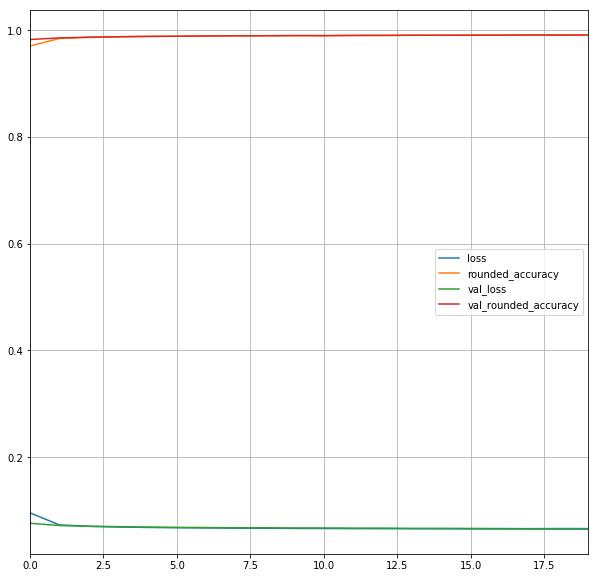

In [0]:
pd.DataFrame(stacked_hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

### 3.1.4 Evaluate the Model

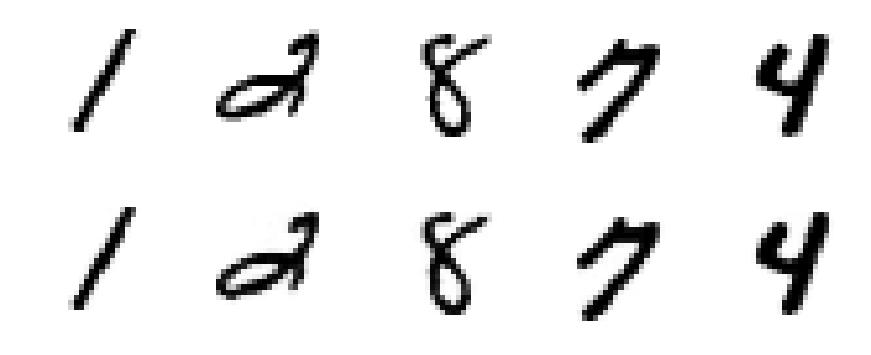

In [0]:
show_reconstructions(stacked_autoencoder, n_images=5)

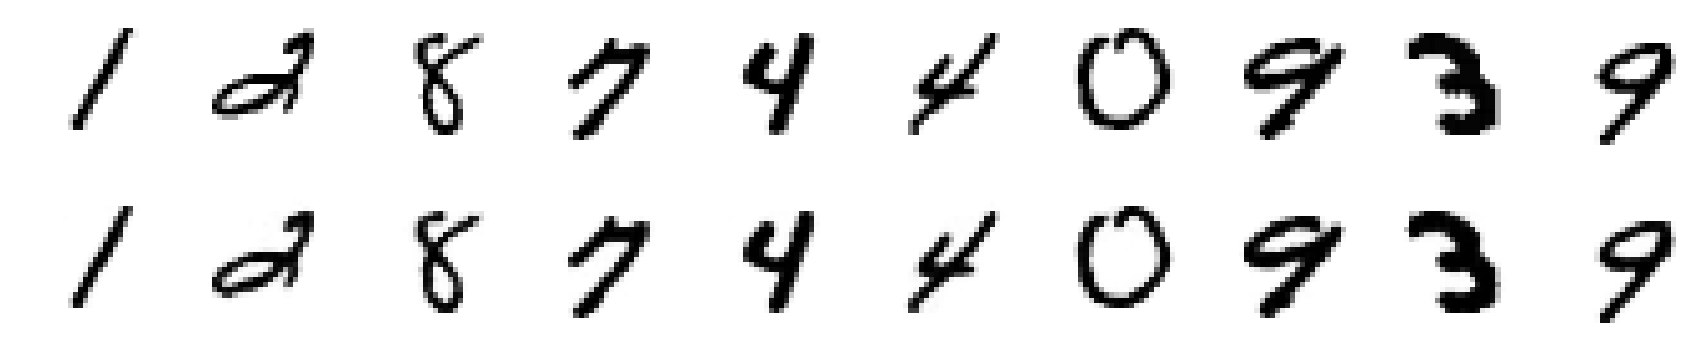

In [0]:
show_reconstructions(stacked_autoencoder, n_images=10)

## 3.2 Question #2 Convolutional Autoencoder

### 3.2.1 Create Model:
1. Encoder(conv, maxpool, conv, maxpool, conv, maxpool). 
2. Decoder (conv, upsample2d, conv, upsample2d, conv, upsample2d, conv)

In [0]:
inputs = keras.Input(shape=(28,28))

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

encoder_cnn = layers.Reshape([28, 28, 1])(inputs)
encoder_cnn = layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu")(encoder_cnn)
encoder_cnn = layers.MaxPool2D(pool_size=2)(encoder_cnn)
encoder_cnn = layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu")(encoder_cnn)
encoder_cnn = layers.MaxPool2D(pool_size=2)(encoder_cnn)
encoder_cnn = layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu")(encoder_cnn)
encoder_cnn = layers.MaxPool2D(pool_size=2)(encoder_cnn)

decoder_cnn = layers.Conv2DTranspose(64, kernel_size=2, strides=1, padding="SAME", activation="selu")(encoder_cnn)
decoder_cnn = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu")(decoder_cnn)
decoder_cnn = layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu")(decoder_cnn)
decoder_cnn = layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid")(decoder_cnn)
output = layers.Reshape([28,28])(decoder_cnn)

conv_autoencoder = keras.Model(inputs, output)
conv_autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=[rounded_accuracy])

In [0]:
conv_autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          1849

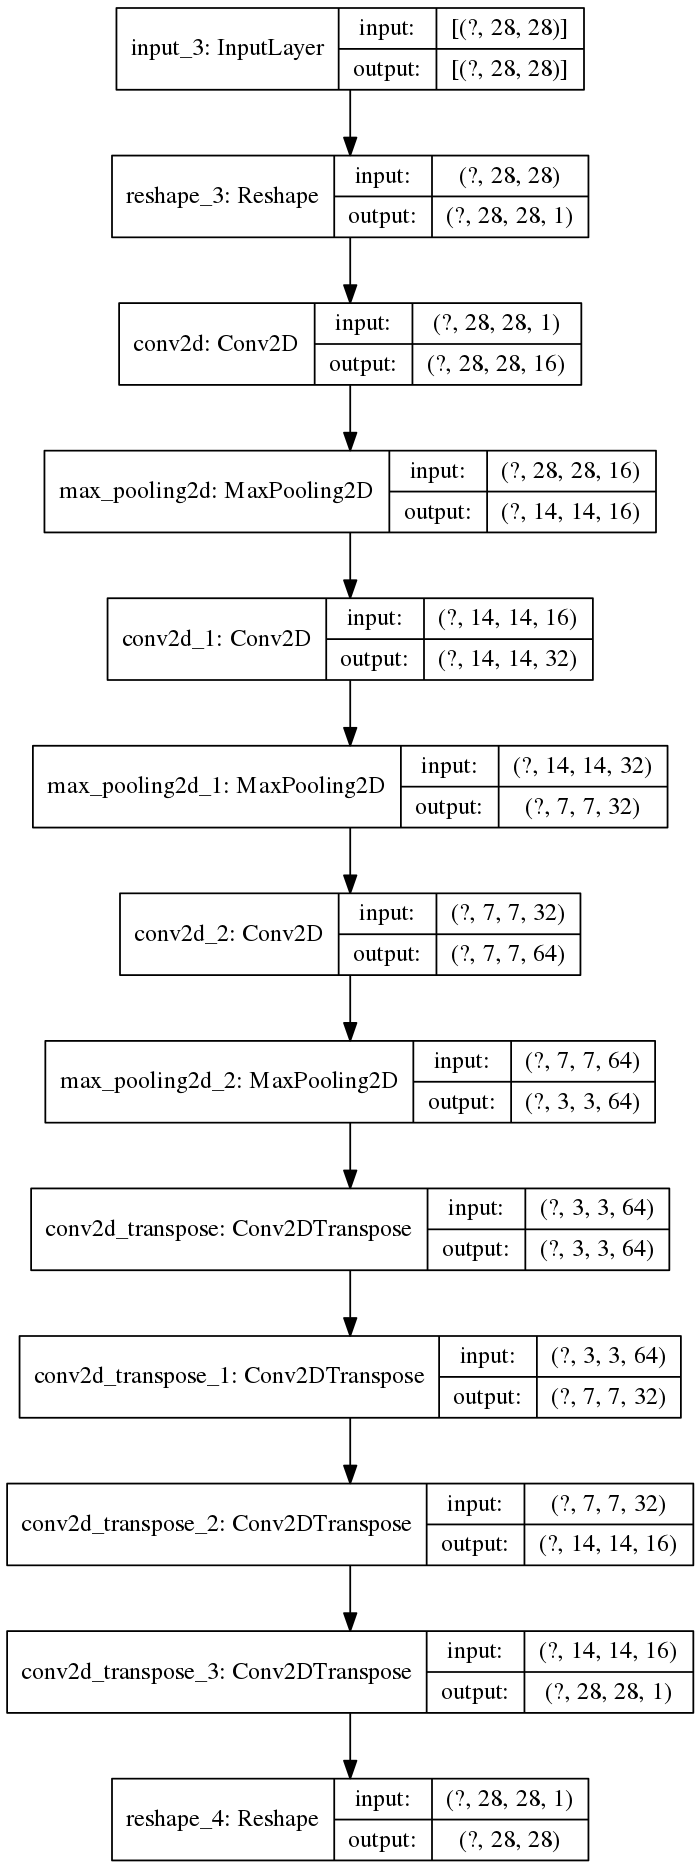

In [0]:
keras.utils.plot_model(conv_autoencoder, to_file='model.png',show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=128)

### 3.2.2 Execute Conv Autoencoder Model:

In [0]:
conv_hist = conv_autoencoder.fit(X_train, X_train, epochs=20,
                                 validation_data=[X_valid, X_valid]
                                 )

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 18s 330us/sample - loss: 0.1120 - rounded_accuracy: 0.9608 - val_loss: 0.0842 - val_rounded_accuracy: 0.9759
Epoch 2/20
55000/55000 [==============================] - 9s 167us/sample - loss: 0.0802 - rounded_accuracy: 0.9783 - val_loss: 0.0783 - val_rounded_accuracy: 0.9798
Epoch 3/20
55000/55000 [==============================] - 9s 164us/sample - loss: 0.0759 - rounded_accuracy: 0.9813 - val_loss: 0.0751 - val_rounded_accuracy: 0.9821
Epoch 4/20
55000/55000 [==============================] - 9s 165us/sample - loss: 0.0737 - rounded_accuracy: 0.9829 - val_loss: 0.0733 - val_rounded_accuracy: 0.9835
Epoch 5/20
55000/55000 [==============================] - 9s 165us/sample - loss: 0.0722 - rounded_accuracy: 0.9840 - val_loss: 0.0722 - val_rounded_accuracy: 0.9842
Epoch 6/20
55000/55000 [==============================] - 9s 164us/sample - loss: 0.0711 - rounded_accuracy: 0.9848 - va

### 3.2.3 Visualize the history of the training

<function matplotlib.pyplot.show(*args, **kw)>

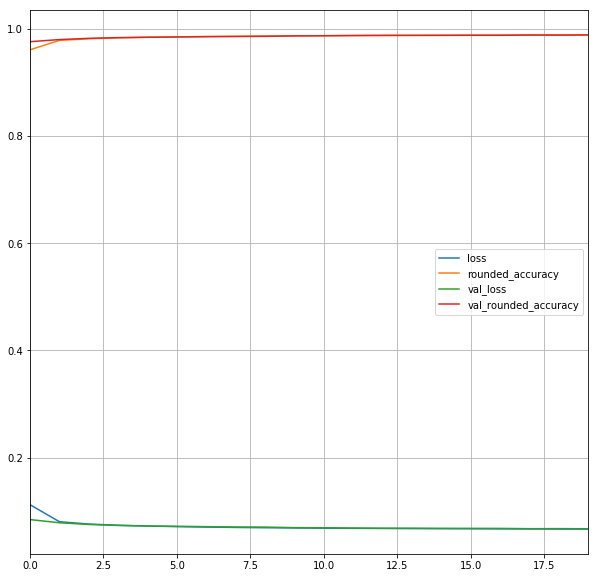

In [0]:
pd.DataFrame(conv_hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

### 3.2.4 Evaluate the Conv Autoencoder Model

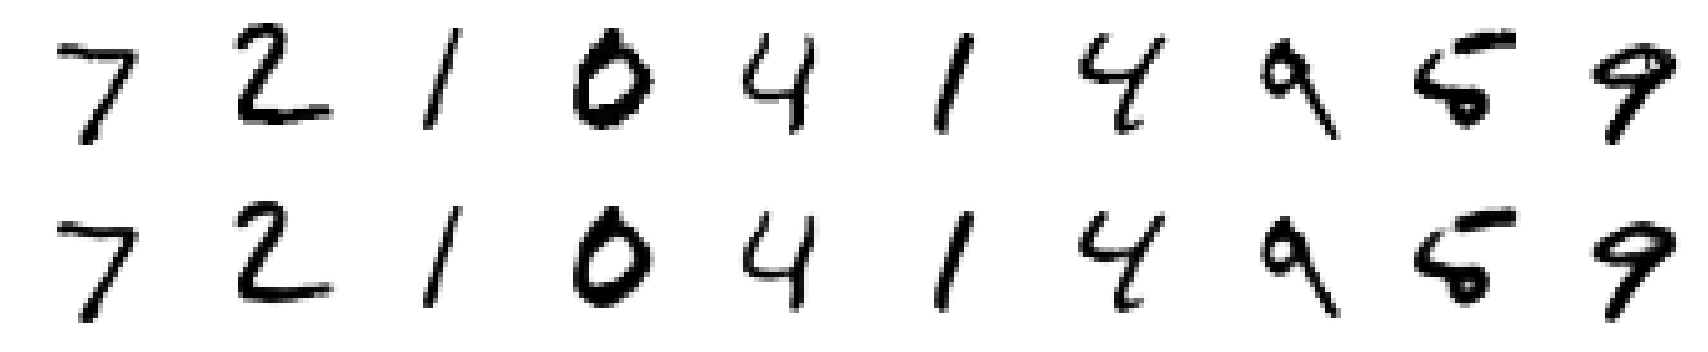

In [0]:
show_reconstructions(conv_autoencoder, images=X_test, n_images=10)

## 3.3 Question #3 VAE Autoencoder

### 3.3.1 Create Model:

In [0]:
inputs = keras.Input(shape=(28,28))

In [0]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

z = Flatten()(inputs)
z = Dense(150, activation="selu")(z)
z = Dense(100, activation="selu")(z)
codings_mean = Dense(codings_size)(z)
codings_log_var = Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = Dense(100, activation="selu")(decoder_inputs)
x = Dense(150, activation="selu")(x)
x = Dense(28 * 28, activation="sigmoid")(x)
outputs = layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])


In [0]:
variational_ae.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model_7 (Model)                 [(None, 10), (None,  134870      input_4[0][0]                    
__________________________________________________________________________________________________
model_8 (Model)                 (None, 28, 28)       134634      model_7[1][2]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           input_4[0][0]                    
____________________________________________________________________________________________

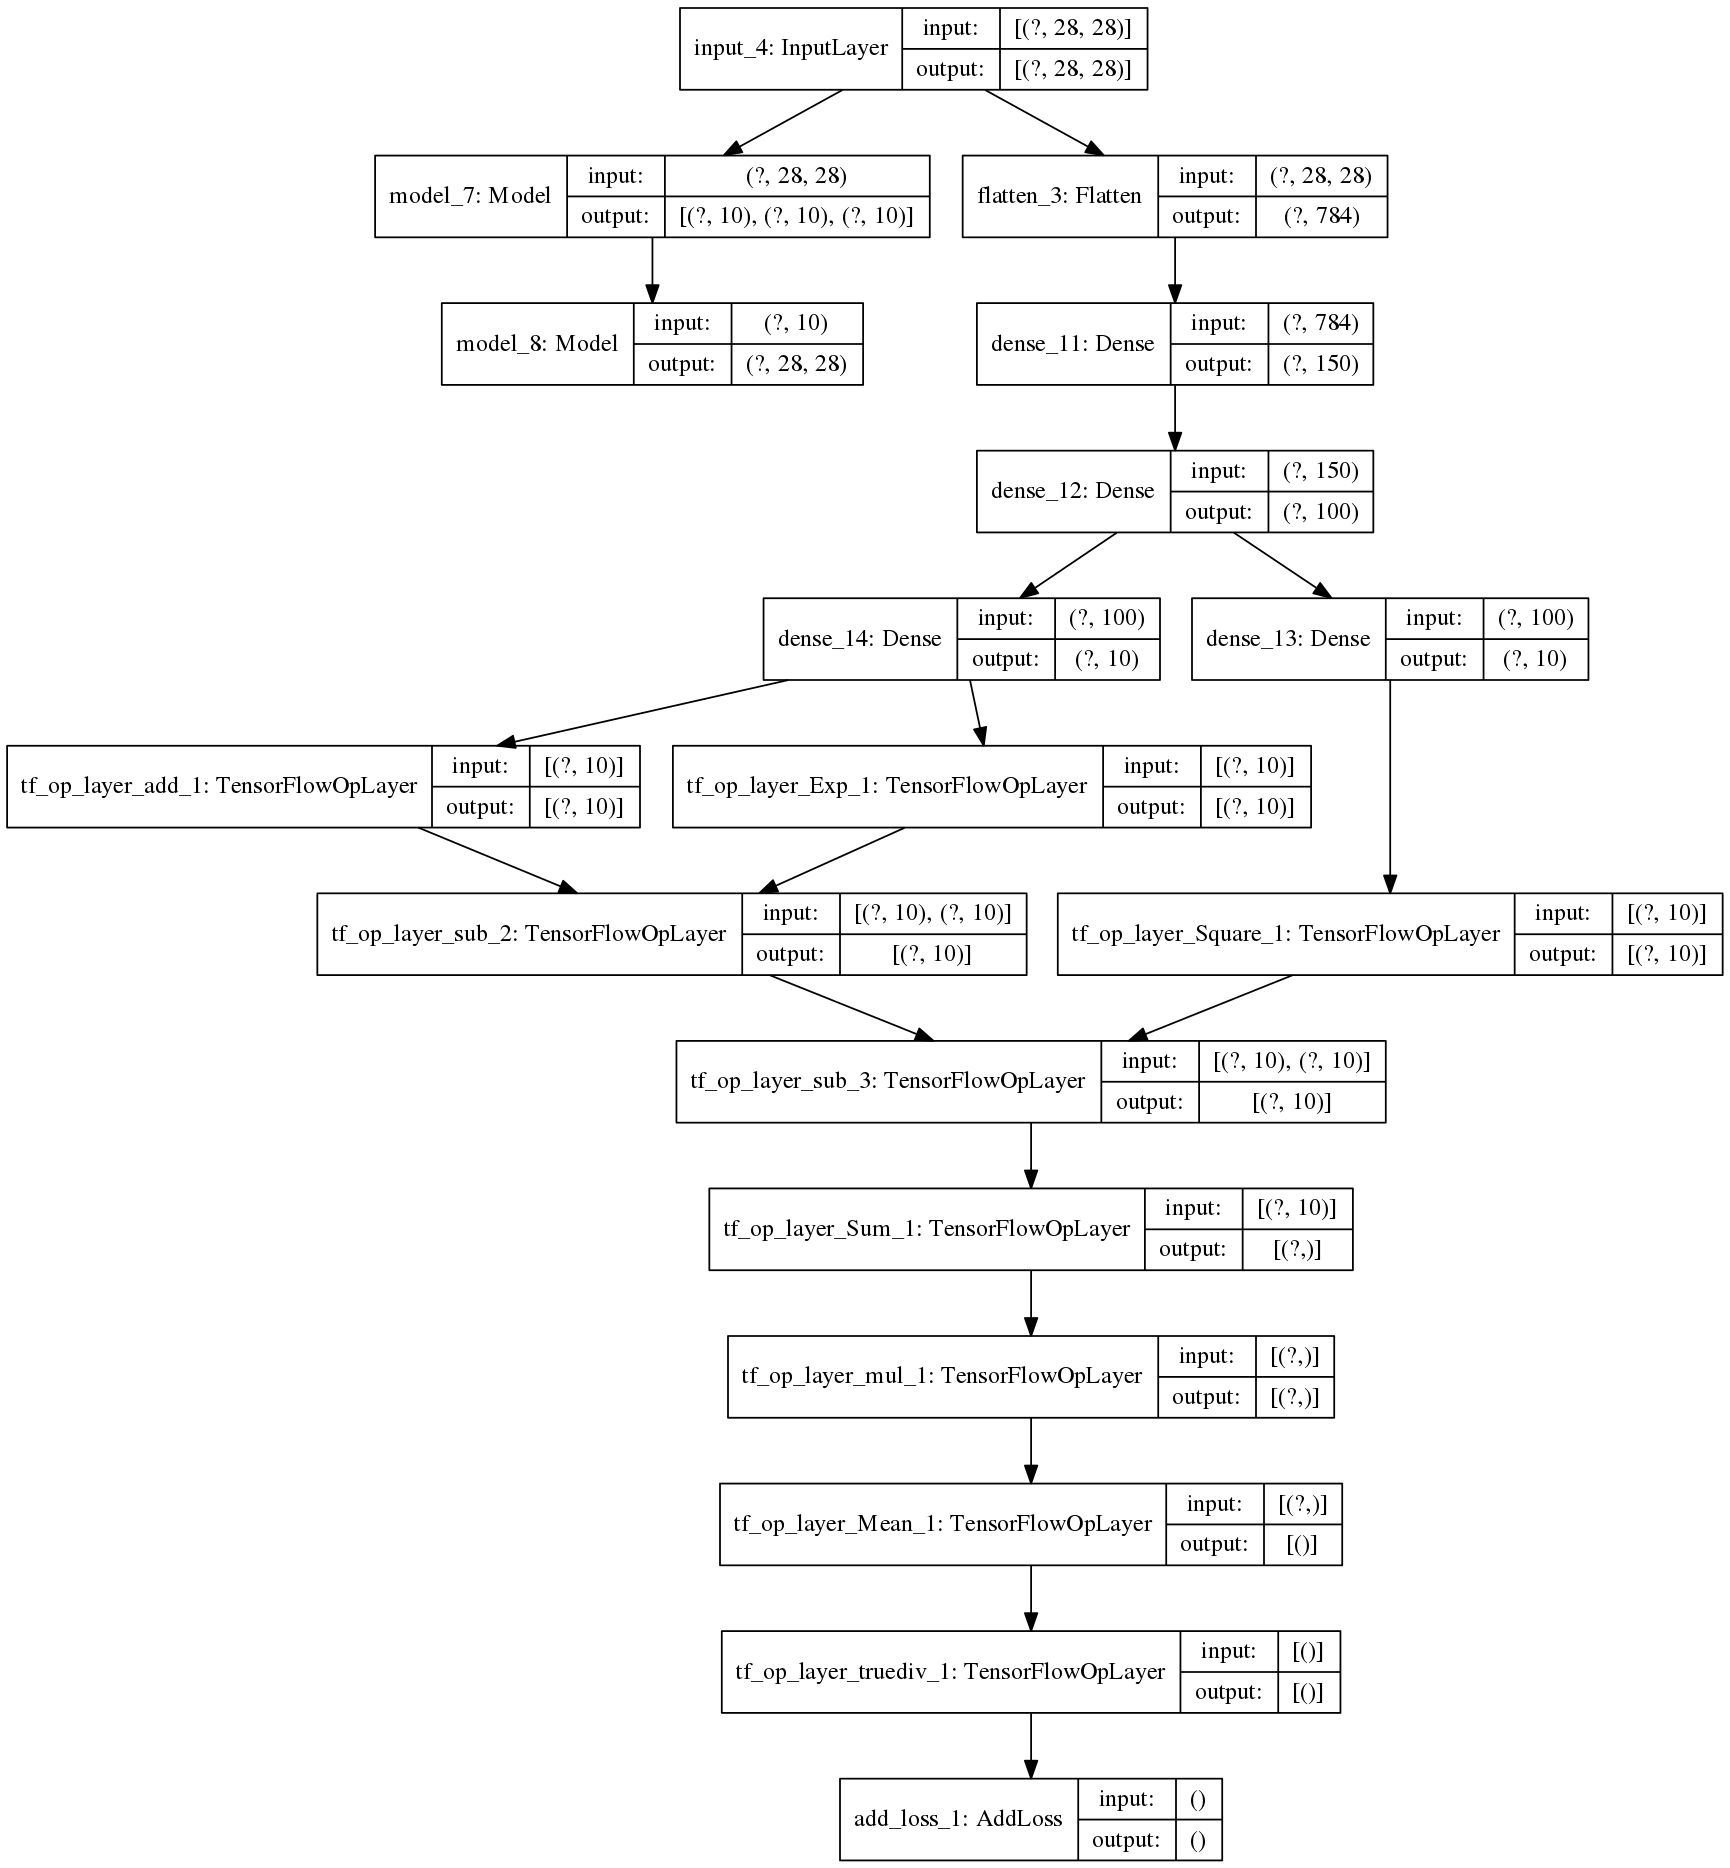

In [0]:
keras.utils.plot_model(variational_ae, to_file='model.png',show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=128)

### 3.2.2 Execute VAE Autoencoder Model:

In [0]:
vae_hist= variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid]
                             )


Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2233 - rounded_accuracy: 0.9053 - val_loss: 0.1873 - val_rounded_accuracy: 0.9271
Epoch 2/25
55000/55000 [==============================] - 3s 46us/sample - loss: 0.1770 - rounded_accuracy: 0.9322 - val_loss: 0.1672 - val_rounded_accuracy: 0.9380
Epoch 3/25
55000/55000 [==============================] - 3s 46us/sample - loss: 0.1654 - rounded_accuracy: 0.9391 - val_loss: 0.1623 - val_rounded_accuracy: 0.9415
Epoch 4/25
55000/55000 [==============================] - 3s 46us/sample - loss: 0.1599 - rounded_accuracy: 0.9426 - val_loss: 0.1585 - val_rounded_accuracy: 0.9431
Epoch 5/25
55000/55000 [==============================] - 3s 47us/sample - loss: 0.1566 - rounded_accuracy: 0.9447 - val_loss: 0.1594 - val_rounded_accuracy: 0.9438
Epoch 6/25
55000/55000 [==============================] - 3s 47us/sample - loss: 0.1542 - rounded_accuracy: 0.9462 - val_loss:

### 3.2.3 Visualize the history of the training

<function matplotlib.pyplot.show(*args, **kw)>

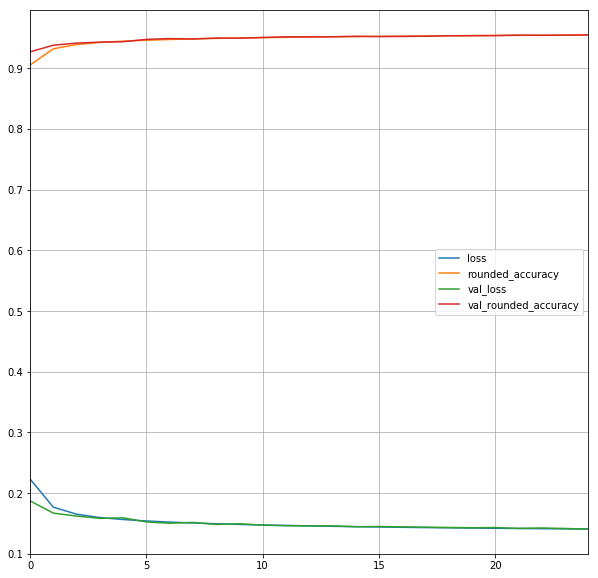

In [0]:
pd.DataFrame(vae_hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

### 3.2.4 Evaluate the VAE Autoencoder Model

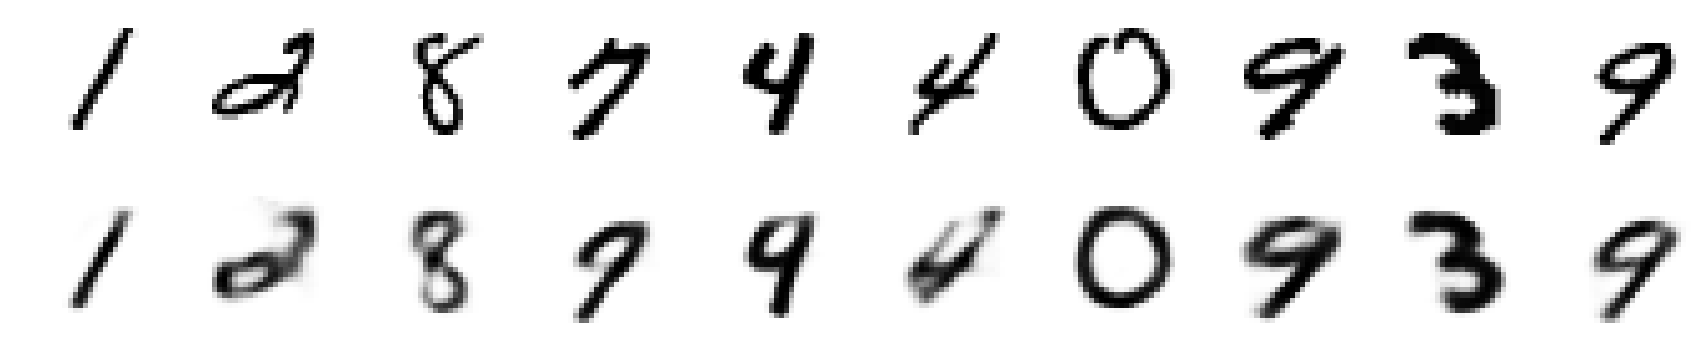

In [0]:
show_reconstructions(variational_ae, images=X_valid, n_images=10)